In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax

idx = pd.IndexSlice

In [2]:
results = pd.read_csv(
    Path.cwd().parent /
    'summaries' /
    'total_summary_flex.csv',
    index_col=[0,1],
    parse_dates=True
    )

model_balancing_volume = results.loc[results.index.get_level_values(1) == 'balancing_volume']
results = results.loc[~(results.index.get_level_values(1) == 'balancing_volume')]

C:\Users\lukas\AppData\Local\Temp\ipykernel_40228\199033386.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  results = pd.read_csv(


In [3]:
balancing_share = 1 - model_balancing_volume['zonal'].mean() / model_balancing_volume['national'].mean()

In [4]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'bmus_prepared.csv', index_col=0)

In [5]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

all_bids = []

for day in tqdm(sorted(model_balancing_volume.index.get_level_values(0).strftime('%Y-%m-%d').unique())):

    try:
        bids = pd.read_csv(Path.cwd().parent / 'data' / 'base' / f'{day}' / 'bids.csv', index_col=[0,1], parse_dates=True)
    except FileNotFoundError:
        continue

    all_bids.append(bids)

all_bids = pd.concat(all_bids)

100%|██████████| 1078/1078 [00:05<00:00, 192.19it/s]


In [6]:
idx = pd.IndexSlice

real_bid_vol = all_bids.loc[
    idx[:,'vol'],
    # idx['2022-11','vol'],
    all_bids.columns.intersection(
        bmus
        .index[bmus.carrier.isin(['onwind', 'offwind', 'cascade', 'ror', 'PHS'])]
        )
    # :
].sum(axis=1)

real_bid_vol.index = real_bid_vol.index.droplevel(1)
# real_bid_vol = real_bid_vol.groupby(real_bid_vol.index.strftime('%Y-%m')).sum().mul(1e-3)
real_bid_vol = real_bid_vol.groupby(real_bid_vol.index.strftime('%Y-%m')).sum().mul(1e-3)

In [7]:
mmb = (
    # model_balancing_volume.loc['2022-11', 'national']
    model_balancing_volume.loc[:, 'national']
    .groupby(
        model_balancing_volume# .loc['2022-11']
        .index
        .get_level_values(0)
        .strftime('%Y-%m')
        # .strftime('%Y-%m-%d')
    ).sum()
    .mul(1e3)
)

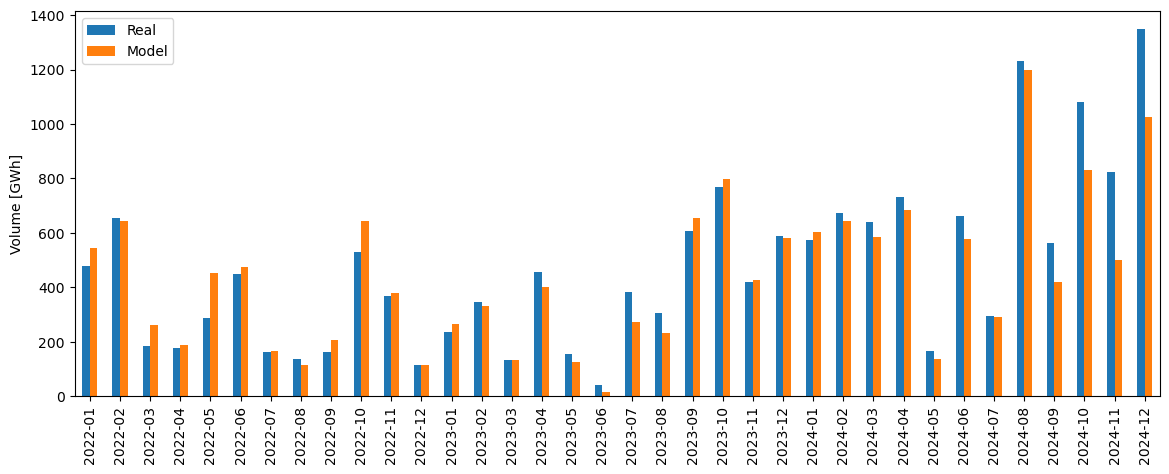

In [8]:
fig, ax = plt.subplots(figsize=(14, 5))

# real_bid_vol.plot.bar(ax=ax)
# mmb.plot.bar(ax=ax, color='red')

plotdata = pd.concat([real_bid_vol, mmb], axis=1)
plotdata.columns = ['Real', 'Model']

plotdata.plot.bar(ax=ax)
ax.set_ylabel('Volume [GWh]')



plt.savefig('balancing_volume_validation.pdf', bbox_inches='tight')
plt.show()

In [9]:
print(plotdata.sum())

Real     16927.751935
Model    15916.831803
dtype: float64


In [10]:
# print('real congestion management bids: ', int(real_bid_vol.drop(index=['2022-11-20', '2022-11-22']).sum().sum()), 'GWh')
# print('model congestion management bids: ', int(mmb.drop(index=['2022-11-20', '2022-11-22']).sum()), 'GWh')
print('real congestion management bids: ', int(real_bid_vol.sum().sum()), 'GWh')
print('model congestion management bids: ', int(mmb.sum()), 'GWh')

real congestion management bids:  16927 GWh
model congestion management bids:  15916 GWh


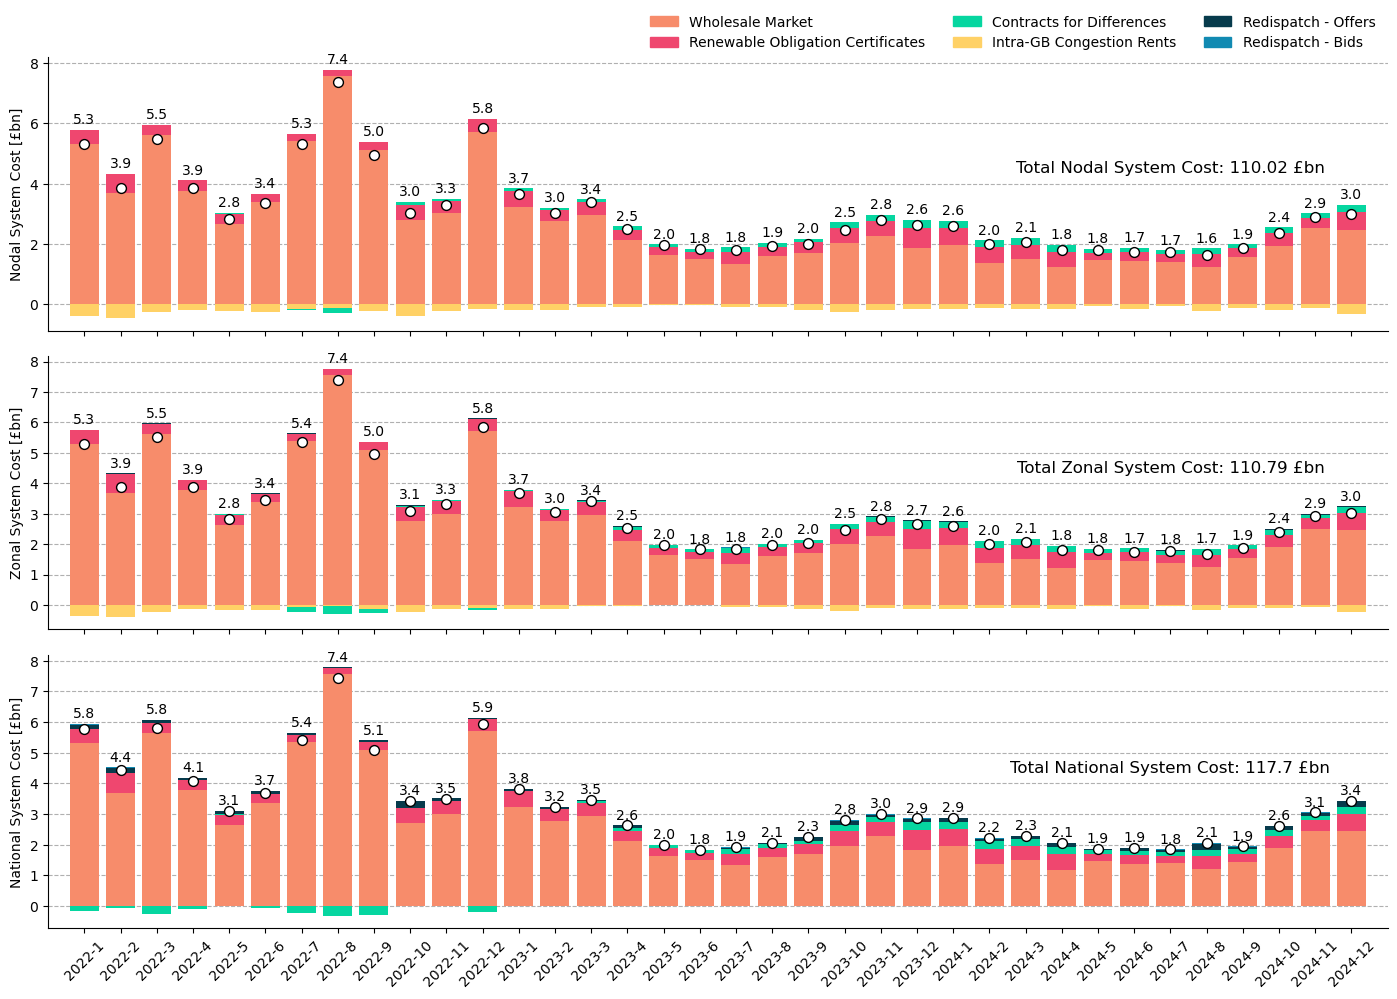

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for col, ax in zip(results.columns, axs):

    ts = results.index.get_level_values(0).unique()

    df_unstack = results.loc[idx[:, :], col].unstack()
    df = df_unstack.groupby([df_unstack.index.year, df_unstack.index.month]).sum().mul(1e-3)

    for m in df.index:
        # stack_to_ax(total_costs, df.loc[[m]], ax)
        stack_to_ax(df.loc[[m]], ax)

    ax.set_ylabel(f'{col.capitalize()} System Cost [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(df))

    total_cost = df.sum().sum()
    ax.text(
        len(df) - 6, 4.5,
        f'Total {col.capitalize()} System Cost: {np.around(total_cost, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )

axs[2].tick_params(axis='x', labelrotation=45)

handles, labels = [], []

for name, nice_name in nice_names.items():

    if name == 'wholesale buying':
        continue
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[0].legend(
    handles,
    labels,
    # title='Cost Factors',
    # bbox_to_anchor=(1.01, 1.2),
    bbox_to_anchor=(0.44, 1.2),
    frameon=False,
    ncol=3
    )


plt.tight_layout()

plt.savefig('total_monthly_costs.pdf')
plt.show()

In [12]:
nquants = len(results.index.get_level_values(1).unique())

total_date_range = pd.date_range(
    results.index.get_level_values(0).min().strftime('%Y-%m'),
    results.index.get_level_values(0).max().strftime('%Y-%m'),
    freq='ME').strftime('%Y-%m')

total_hh = pd.date_range(
    results.index.get_level_values(0).min().strftime('%Y-%m-%d'),
    results.index.get_level_values(0).max().strftime('%Y-%m-%d'),
    freq='30min')

missing_share = pd.Series(np.nan, total_date_range)

for m in total_date_range:

    n_modelled = len(results.loc[idx[m, :], :]) / nquants
    n_total = pd.date_range(m, pd.Timestamp(m) + pd.offsets.MonthEnd(1), freq='30min')

    missing_share[m] = 1 - n_modelled / len(n_total)

##### Combined: Total Costs National, Total Costs Zonal, Difference

In [13]:
results.columns

Index(['nodal', 'zonal', 'national'], dtype='object')

In [14]:
def plot_stacked_horizontal_bar(series, ax, right_tick=True):
    """
    Plot a horizontal stacked bar chart with negative values to the left and positive values to the right.
    
    Parameters:
    -----------
    series : pd.Series
        Series containing values to plot, with negative and positive values.
    ax : matplotlib.axes.Axes
        The axes to plot on.
    """
    # Separate positive and negative values
    pos_series = series[series > 0].copy()
    neg_series = series[series < 0].copy()
    
    # Sort values for better visualization
    pos_series = pos_series.sort_values(ascending=False)
    neg_series = neg_series.sort_values(ascending=True)
    
    # Calculate cumulative sums for stacking
    # pos_cumsum = pos_series.cumsum()
    # neg_cumsum = neg_series.cumsum()
    
    # Calculate the total negative value (for x-axis alignment)
    total_neg = neg_series.sum()
    
    # Plot negative values (to the left)
    left = total_neg
    for idx, val in neg_series.items():
        width = abs(val)
        left += width
        ax.barh(0, -width, left=left, height=0.5, label=idx, color=color_dict.get(idx, 'gray'))
    
    # Plot positive values (to the right)
    left = 0
    for idx, val in pos_series.items():
        ax.barh(0, val, left=left, height=0.5, label=idx, color=color_dict.get(idx, 'gray'))
        left += val
    
    # Set x-ticks with one tick at the boundary between negative and positive

    ax.scatter([total_neg + pos_series.sum()], [0], color='white', edgecolor='black', s=100, marker='o')

    # ax.set_xticks([0, total_neg, total_neg + pos_series.sum()])
    # ax.set_xticklabels(['0', f'{total_neg:.1f}', f'{total_neg + pos_series.sum():.1f}'])
    # Remove y-ticks and set labels
    xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()

    # Add the key points to the x-ticks without creating text objects
    more_ticks = [0, total_neg]
    if right_tick:
        more_ticks.append(total_neg + pos_series.sum())
    xticks = np.unique(np.concatenate([xticks, more_ticks]))
    xticklabels = [f'{x:.1f}' for x in xticks]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_yticks([])
    ax.set_xlabel('(£bn)')
    # ax.axvline(x=total_neg, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlim(total_neg, pos_series.sum())
    ax.set_ylim(-0.25, 0.25)

    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    
    return ax

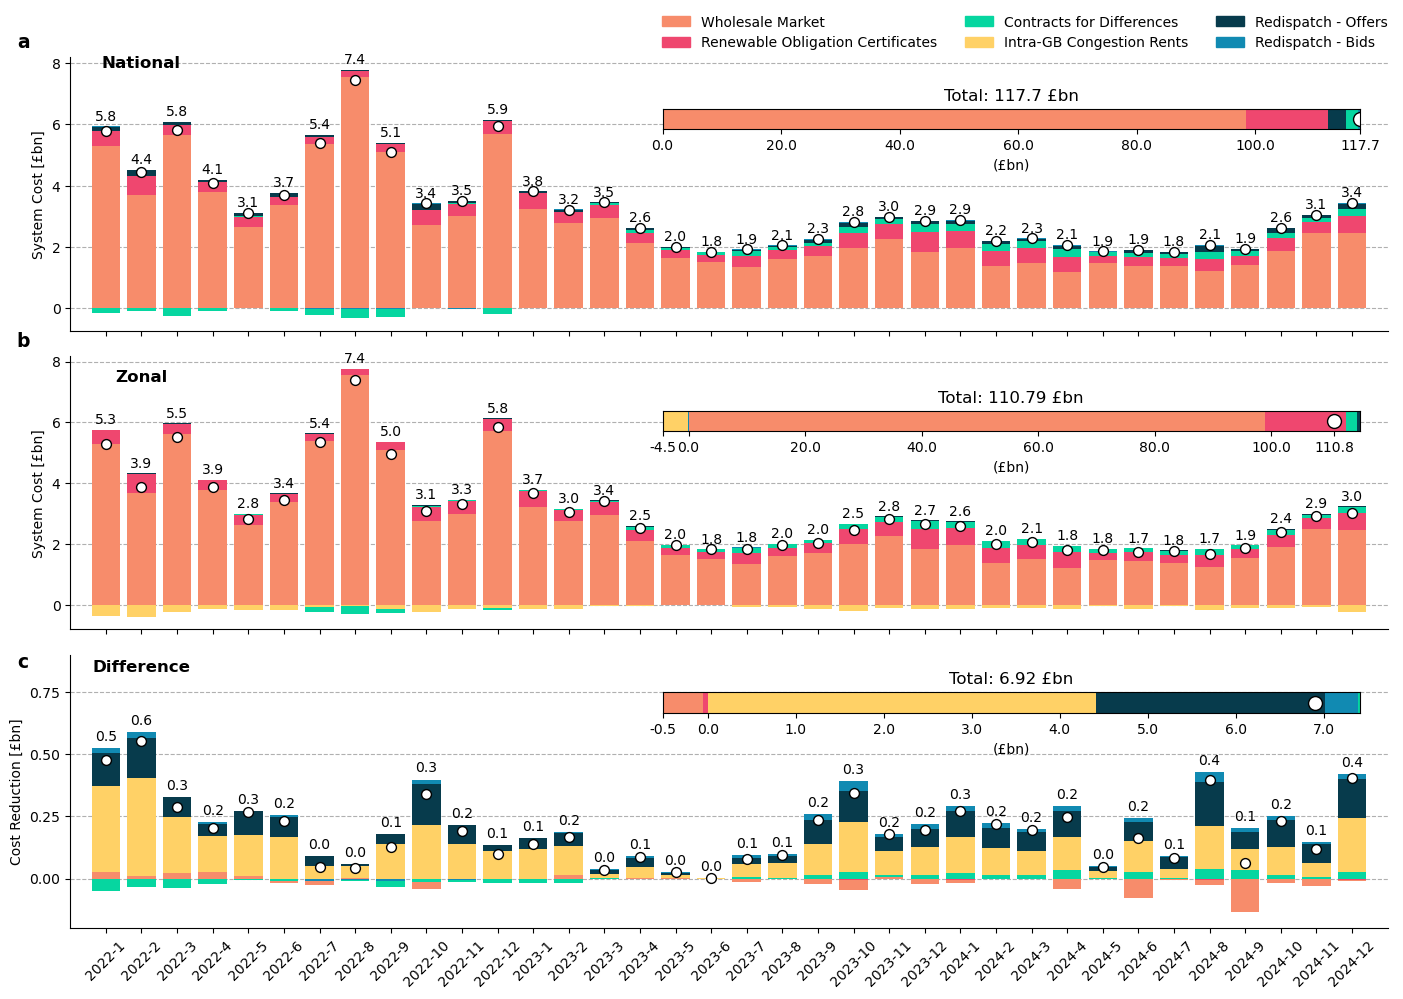

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

totals = {}

for col, ax in zip(['national', 'zonal'], axs[:2]):

    ts = results.index.get_level_values(0).unique()

    df_unstack = results.loc[idx[:, :], col].unstack()
    df = df_unstack.groupby([df_unstack.index.year, df_unstack.index.month]).sum().mul(1e-3)

    for m in df.index:
        # stack_to_ax(total_costs, df.loc[[m]], ax)
        stack_to_ax(df.loc[[m]], ax)

    ax.set_ylabel(f'System Cost [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(df))

    total_cost = df.sum().sum()
    totals[col] = total_cost

    '''
    ax.text(
        len(df) - 6, 5,
        f'Total: {np.around(total_cost, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )
    '''
    ax.text(
        1, {'national': 8, 'zonal': 7.5}[col],
        f'{col.capitalize()}',
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        # transform=ax.transAxes
    )
    ax.set_yticks([0, 2, 4, 6, 8])


    y_shift = 0.01 if col == 'zonal' else 0.04

    # Create a new axis based on relative coordinates to ax
    new_ax = ax.figure.add_axes([
        ax.get_position().x0 + 0.32, 
        ax.get_position().y0 + ax.get_position().height * 0.8 + y_shift, 
        ax.get_position().width * 0.6, 
        ax.get_position().height * 0.09
        ])

    plot_stacked_horizontal_bar(df.sum(), new_ax)
    new_ax.set_title(f'Total: {np.around(total_cost, decimals=2)} £bn')
    


for layout, ax in zip(['zonal'], axs[2:]):

    ss = (results['national'] - results[layout]).unstack()

    ss = (
        ss
        .groupby([ss.index.year, ss.index.month]).sum().mul(1e-3)
    )
    for m in ss.index:
        stack_to_ax(ss.loc[[m]], ax, text_y_offset=0.03)

    ax.set_ylabel(f'Cost Reduction [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(ss))

    total_cost = ss.sum().sum()

    if layout == 'zonal':
        y = 0.625
    else:
        y = 0.65

    total_diff = totals['national'] - totals[layout]

    '''
    ax.text(
        len(ss) - 6, y,
        f'Total: {np.around(total_diff, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )
    '''

    new_ax = ax.figure.add_axes([
        ax.get_position().x0 + 0.32,
        ax.get_position().y0 + ax.get_position().height * 0.8 + 0.0, 
        ax.get_position().width * 0.6, 
        ax.get_position().height * 0.09
        ])

    plot_stacked_horizontal_bar(ss.sum(), new_ax, right_tick=False)
    new_ax.set_title(f'Total: {np.around(total_diff, decimals=2)} £bn')

    ax.text(
        1, 0.85,
        'Difference',
        ha='center',
        va='center',
        fontweight='bold',
        fontsize=12,
        # transform=ax.transAxes
    )
    ax.set_yticks([0, 0.25, 0.5, 0.75])
    ax.set_ylim(-0.2, 0.9)


axs[2].tick_params(axis='x', labelrotation=45)

handles, labels = [], []

for name, nice_name in nice_names.items():

    if name == 'wholesale buying':
        continue
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[0].legend(
    handles,
    labels,
    # title='Cost Factors',
    # bbox_to_anchor=(1.01, 1.2),
    bbox_to_anchor=(0.44, 1.2),
    frameon=False,
    ncol=3
    )

plt.tight_layout()

for ax, text, y in zip(axs, ['a', 'b', 'c'], [8.5, 8.5, 0.85]):
    ax.text(
        -2.5, y, text, weight='bold', fontsize=13.5,
    )

plt.savefig('total_monthly_costs_w_comparison.pdf')
plt.show()

In [16]:
rev_nat = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_national.csv', index_col=[0,1], parse_dates=True)
rev_zon = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_zonal.csv', index_col=[0,1], parse_dates=True)

interconnectors = [
    'IFA1',
    'Moyle',
    'BritNed',
    'IFA2',
    'EastWest',
    'ElecLink',
    'NSL',
    'Nemo'
]

# Remove interconnectors from revenue dataframes
rev_nat = rev_nat.loc[~rev_nat.index.get_level_values(0).isin(interconnectors)]
rev_zon = rev_zon.loc[~rev_zon.index.get_level_values(0).isin(interconnectors)]

from plotting_constants import color_dict

In [17]:
ts = pd.read_csv(
    Path.cwd().parent / 'summaries' / 'total_summary_flex.csv', 
    index_col=[0,1], 
    # parse_dates=[0]
    )
ts = ts.loc[idx[:, 'balancing_volume'], ['zonal', 'national']]
ts = ts.groupby(ts.index.get_level_values(0).str[:7]).sum().mul(1e3)

curtailment = ts['national'] - ts['zonal']

who_diff = rev_zon.loc[idx[:, 'wholesale_revenue'], :].sum() - rev_nat.loc[idx[:, 'wholesale_revenue'], :].sum()
who_diff = who_diff.groupby(who_diff.index.get_level_values(0).str[:7]).sum().mul(1e-9)

who_diff

2022-01   -0.414435
2022-02   -0.446026
2022-03   -0.271182
2022-04   -0.178047
2022-05   -0.173786
2022-06   -0.159567
2022-07   -0.031082
2022-08   -0.054622
2022-09   -0.140581
2022-10   -0.207242
2022-11   -0.147574
2022-12   -0.112527
2023-01   -0.131392
2023-02   -0.151154
2023-03   -0.021333
2023-04   -0.057021
2023-05   -0.016365
2023-06   -0.001038
2023-07   -0.046112
2023-08   -0.063604
2023-09   -0.119890
2023-10   -0.192054
2023-11   -0.115895
2023-12   -0.112575
2024-01   -0.149026
2024-02   -0.119278
2024-03   -0.106281
2024-04   -0.114774
2024-05   -0.031465
2024-06   -0.083963
2024-07   -0.036914
2024-08   -0.185189
2024-09    0.012805
2024-10   -0.110481
2024-11   -0.041897
2024-12   -0.238204
dtype: float64

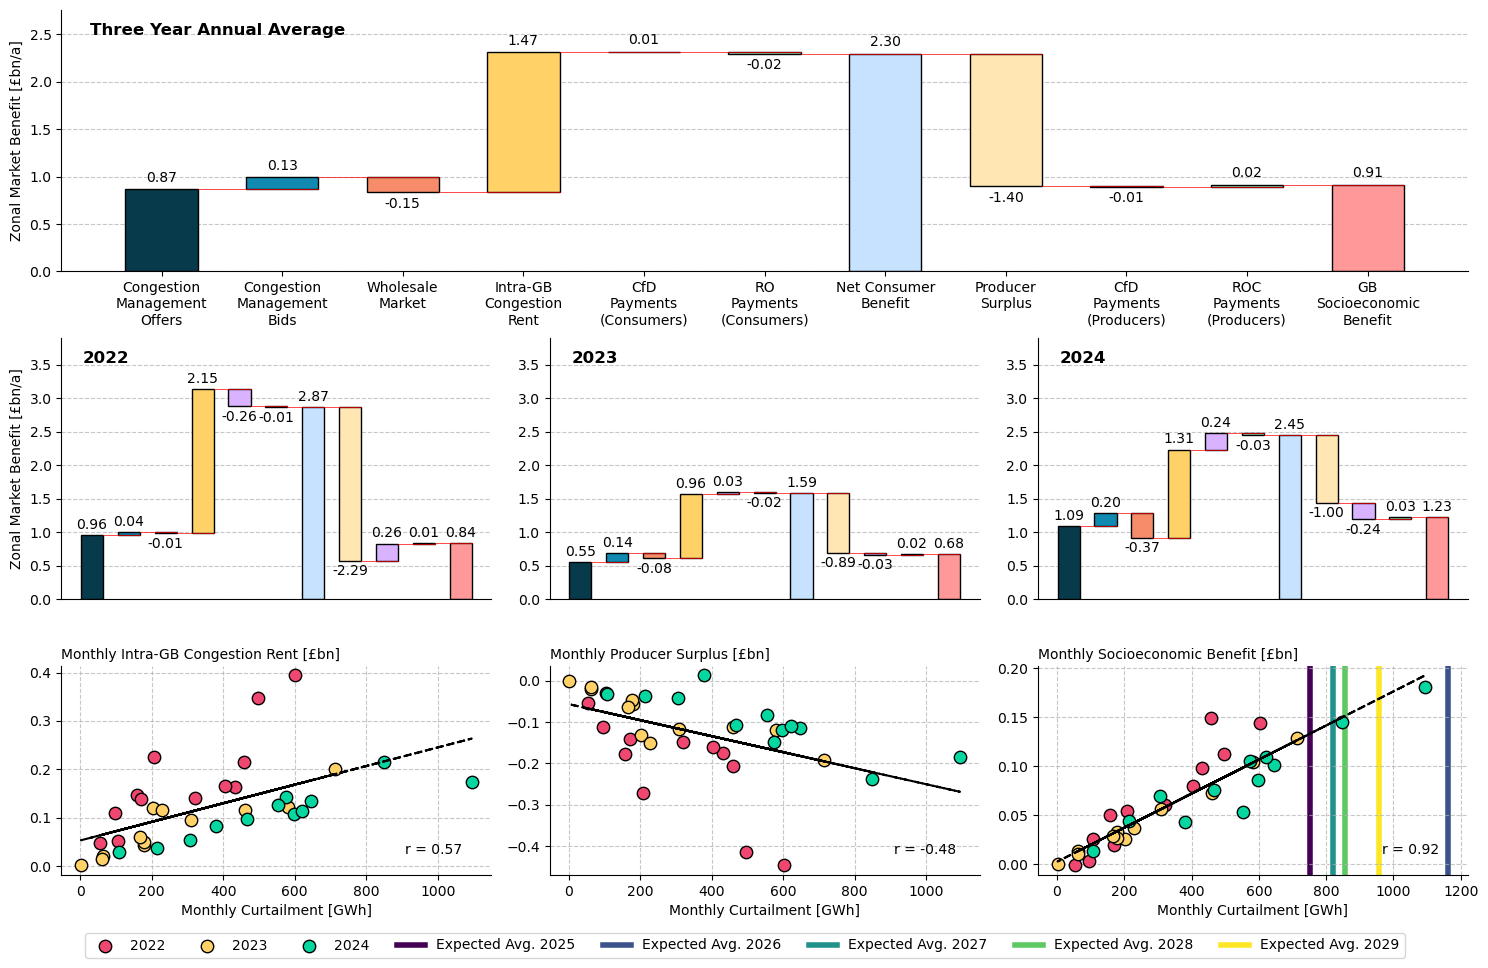

In [23]:
corr_plot = ss.copy()

corr_plot['curtailment'] = curtailment.values
corr_plot['producer_surplus'] = who_diff.values

corr_plot.drop(columns=['cfd_payments', 'roc_payments'], inplace=True)

corr_plot['welfare'] = corr_plot.drop(columns=['curtailment']).sum(axis=1)

# Define the columns to plot in correlation plots
columns_to_plot = ['congestion_rent', 'producer_surplus', 'welfare']

# Define colors for each year for correlation plots
colors = {2022: '#ef476f', 2023: '#ffd166', 2024: '#06d6a0'}

# Create a figure with 3 rows - top row has 1 plot, middle row has 3 plots, bottom row has 3 correlation plots
fig, axs = plt.subplots(3, 3, figsize=(15, 10), 
                        gridspec_kw={'height_ratios': [1, 1, 0.8], 
                                    'width_ratios': [1, 1, 1]})

# Make the top plot span all three columns
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:
    ax.remove()
axs[0, 0] = fig.add_subplot(gs[0, :])

# Define the years to process
years = ['total', '2022', '2023', '2024']

# Process each year and plot on the appropriate axis
for i, year in enumerate(years):
    if i == 0:
        ax = axs[0, 0]  # Top row for 'total'
    else:
        ax = axs[1, i-1]  # Middle row for individual years
    
    # Process data for the current year
    if year != 'total':
        rev_nat_year = rev_nat.loc[:, rev_nat.columns.str.contains(year)]
        rev_zon_year = rev_zon.loc[:, rev_zon.columns.str.contains(year)]
    else:
        rev_nat_year = rev_nat.mul(1/3)
        rev_zon_year = rev_zon.mul(1/3)

    idx = pd.IndexSlice
    rev_nat_val = rev_nat_year.loc[idx[:, 'wholesale_revenue'], :].sum().sum() / 1e9
    rev_zon_val = rev_zon_year.loc[idx[:, 'wholesale_revenue'], :].sum().sum() / 1e9

    diff = rev_zon_val - rev_nat_val

    wf = pd.Series(
        index=[
            'offer_cost',
            'bid_cost',
            'wholesale',
            'congestion_rent',
            'cfd_payments_consumer',
            'roc_payments_consumer',
            'net_consumer_benefit',
            'producer_surplus',
            'cfd_payments_producer',
            'roc_payments_producer',
            'socioeconmic_benefit'
            ],
    )

    if year != 'total':
        hold = ss.loc[idx[int(year), :]].sum()
    else:
        hold = ss.sum() / 3

    wf.loc[wf.index.intersection(hold.index)] = hold.loc[wf.index.intersection(hold.index)]

    wf.loc['cfd_payments_consumer'] = hold.loc['cfd_payments']
    wf.loc['cfd_payments_producer'] = - hold.loc['cfd_payments']

    wf.loc['roc_payments_consumer'] = hold.loc['roc_payments']
    wf.loc['roc_payments_producer'] = - hold.loc['roc_payments']

    wf.loc['net_consumer_benefit'] = hold.sum()
    wf.loc['producer_surplus'] = diff + hold.loc['bid_cost']

    wf.loc['socioeconmic_benefit'] = wf.loc['net_consumer_benefit'] + wf.loc['producer_surplus'] - wf.loc['cfd_payments_consumer'] - wf.loc['roc_payments_consumer']

    # Define the components for the waterfall chart
    components = wf.index.tolist()
    values = wf.values

    # Use the color dictionary or default to a standard color if not in dict
    # Define fallback colors for components not in color_dict
    fallback_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#d9b3ff', '#b3ffcc', '#c6e2ff', '#ffe6b3', '#d9b3ff', '#b3ffcc']
    colors_wf = []
    for j, component in enumerate(components):
        if component in color_dict:
            colors_wf.append(color_dict[component])
        else:
            # Use a fallback color from our list, cycling if needed
            fallback_idx = j % len(fallback_colors)
            colors_wf.append(fallback_colors[fallback_idx])

    # Starting positions for each bar
    bottoms = np.zeros_like(values)

    # First 6 entries begin at the height of the previous one
    for j in range(1, 6):
        bottoms[j] = bottoms[j-1] + values[j-1]

    # net_consumer_benefit starts at 0
    bottoms[6] = 0

    # The next 3 entries continue from previous bar's height
    for j in range(7, 10):
        bottoms[j] = bottoms[j-1] + values[j-1]

    # socioeconomic_benefit starts from the bottom
    bottoms[10] = 0

    # Create the bars
    running_total = 0
    width = 0.6
    for j, (component, value, bottom, color) in enumerate(zip(components, values, bottoms, colors_wf)):
        ax.bar(j, value, bottom=bottom, color=color, edgecolor='black', label=component, width=width)
        
        # Add value labels on the bars
        if value >= 0:
            va = 'bottom'
            y_pos = bottom + value + 0.05
        else:
            va = 'top'
            y_pos = bottom + value - 0.05
        
        ax.text(j, y_pos, f'{value:.2f}', ha='center', va=va)
        
        if j > 0 and j < 6:  # First section (up to net_consumer_benefit)
            ax.plot([j-1 + width/2, j + width/2], [running_total, running_total], 'r', linewidth=.5)
            running_total += value
        elif j == 6:  # Reset for net_consumer_benefit
            running_total = value
            ax.plot([j-1 + width/2, j + width/2], [running_total, running_total], 'r', linewidth=.5)
        elif j > 6 and j < 11:  # Second section (up to socioeconmic_benefit)
            ax.plot([j-1 + width/2, j + width/2], [running_total, running_total], 'r', linewidth=.5)
            running_total += value
        elif j == 0:
            running_total = value

    friendly_labels = {
        'offer_cost': 'Congestion\nManagement\nOffers',
        'bid_cost': 'Congestion\nManagement\nBids',
        'wholesale': 'Wholesale\nMarket',
        'congestion_rent': 'Intra-GB\nCongestion\nRent',
        'cfd_payments_consumer': 'CfD\nPayments\n(Consumers)',
        'roc_payments_consumer': 'RO\nPayments\n(Consumers)',
        'net_consumer_benefit': 'Net Consumer\nBenefit',
        'producer_surplus': 'Producer\nSurplus',
        'cfd_payments_producer': 'CfD\nPayments\n(Producers)',
        'roc_payments_producer': 'RO\nPayments\n(Producers)',
        'socioeconmic_benefit': 'GB\nSocioeconomic\nBenefit'
    }

    if i < 2:
        ax.set_ylabel('Zonal Market Benefit [£bn/a]')
    
    # Set xticks only for the top row, remove for bottom row
    if i == 0:  # Top row
        ax.set_xticks(range(len(components)))
        ax.set_xticklabels([friendly_labels[comp] for comp in components])
    else:  # Middle row
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Add title for each subplot
    if year == 'total':
        # Add the year as text in the upper left corner instead of using a legend
        ax.text(0.02, 0.95, f'Three Year Annual Average', transform=ax.transAxes, 
                fontsize=12, fontweight='bold', va='top', ha='left')
    else:
        # Add the year as text in the upper left corner instead of using a legend
        ax.text(0.05, 0.95, f'{year}', transform=ax.transAxes, 
                fontsize=12, fontweight='bold', va='top', ha='left')

    # Add a grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    # Adjust y-axis limits
    if i == 0:
        ax.set_ylim(0, wf.max() * 1.2)
    else:
        ax.set_ylim(0, 3.9)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add correlation plots in the bottom row
markers = []
for i, col in enumerate(columns_to_plot):
    ax = axs[2, i]
    
    # Plot points with different colors based on year
    for year in [2022, 2023, 2024]:
        year_data = corr_plot.loc[year]
        scatter = ax.scatter(
            year_data['curtailment'], 
            year_data[col],
            s=80,
            color=colors[year],
            edgecolor='k',
            label=year if i == 0 else None  # Only add to legend for the first subplot
        )
        if i == 0:
            markers.append(scatter)
            
    
    # Add trend line for all data
    z = np.polyfit(corr_plot['curtailment'], corr_plot[col], 1)
    p = np.poly1d(z)
    ax.plot(corr_plot['curtailment'], p(corr_plot['curtailment']), "k--")
    ax.set_xlabel('Monthly Curtailment [GWh]')
    ax.set_ylabel('')
    
    # Add frontend-friendly strings for y-quantities
    if col == 'congestion_rent':
        ax.text(-0., 1.02, 'Monthly Intra-GB Congestion Rent [£bn]', transform=ax.transAxes, ha='left', va='bottom')
    elif col == 'producer_surplus':
        ax.text(-0., 1.02, 'Monthly Producer Surplus [£bn]', transform=ax.transAxes, ha='left', va='bottom')
    elif col == 'welfare':
        ax.text(-0., 1.02, 'Monthly Socioeconomic Benefit [£bn]', transform=ax.transAxes, ha='left', va='bottom')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid and set it below the plot elements
    ax.grid(axis='both', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    # Add correlation coefficient
    corr = np.corrcoef(corr_plot['curtailment'], corr_plot[col])[0, 1]
    ax.annotate(f"r = {corr:.2f}", xy=(0.8, 0.1), xycoords='axes fraction')

expected_curtailment = { # from https://www.neso.energy/document/322331/download, slide 32
    '2025': 11_000 / 12 * balancing_share,
    '2026': 17_000 / 12 * balancing_share,
    '2027': 12_000 / 12 * balancing_share,
    '2028': 12_500 / 12 * balancing_share,
    '2029': 14_000 / 12 * balancing_share,
}

# Add vertical lines for expected curtailment in the bottom right plot (welfare)
ax = axs[2, 2]  # Bottom right plot
cmap = plt.cm.viridis  # Use viridis colormap
forecast_lines = []
years = list(expected_curtailment.keys())
for i, year in enumerate(years):
    # Calculate color position in the colormap
    color_pos = i / (len(years) - 1)
    color = cmap(color_pos)
    # Add vertical line
    line = ax.axvline(x=expected_curtailment[year], color=color, linestyle='-', linewidth=4, zorder=0)
    forecast_lines.append(line)

# Add a single legend for the correlation plots and forecast lines
legend_elements = [(markers[i], f'{2022+i}') for i in range(len(markers))]
legend_elements += [(forecast_lines[i], f'Expected Avg. {years[i]}') for i in range(len(forecast_lines))]

fig.legend([elem[0] for elem in legend_elements], 
           [elem[1] for elem in legend_elements],
           loc='lower center', ncol=len(legend_elements), bbox_to_anchor=(0.5, 0.03),
           handler_map={type(forecast_lines[0]): plt.matplotlib.legend_handler.HandlerLine2D()})

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # Make more room for the expanded legend

plt.savefig('socioeconomic_benefits_with_correlations.pdf', bbox_inches='tight')
plt.show()